In [37]:
import numpy as np
import pointprocesses as pp
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 100

The _likelihood function_ associated with a point process
$$\tilde N = {(t_i, \lambda_{t_i})}_i$$
with intensity parameterised by $\Theta\in\mathcal T$ is given by the probability of having $\tilde N$ under $\Theta$:
$$
\mathcal L(\Theta\,|\,\tilde N) = \mathbb P() = \exp\left(-\int_0^T \lambda(t)\,\mathrm dt \right)\prod_{i=1}^{N_T}\lambda(t_i)
$$

In [4]:
def mle_estimator(processes, tmax):
    process_sizes = np.array([len(p) for p in processes])
    return process_sizes.mean()/tmax

In [5]:
tmax = 20.0
lbda = 25
processes = [pp.poisson_process(tmax, lbda) for _ in range(1000)]

In [6]:
mle_estimator(processes, tmax)

25.024350000000002

In [21]:
single_proc = processes[0]

single_proc = single_proc.reshape((1, single_proc.shape[0]))
print(single_proc.shape)

(1, 521)


In [29]:
def pois_lik(data, lbda, tmax):
    """
    Log-likelihood implemented in Python.
    """
    n = data.shape[0]
    return np.power(lbda, n)*np.exp(-lbda*tmax)

In [48]:
pois_lik?

Signature: pois_lik(data, lbda, tmax)
Docstring: Log-likelihood implemented in Python.
File:      ~/Documents/etudes/map511-p3a/notebooks/<ipython-input-29-865cd2362b4c>
Type:      function


In [46]:
%%timeit
pois_lik(single_proc, lbda, tmax)

5.3 µs ± 53.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [47]:
%%timeit
pp.likelihood.poisson_likelihood(single_proc, lbda, tmax)

4.17 µs ± 130 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Variable Poisson process

In [12]:
def intensity(x):
    return 5*(1- np.exp(-2*x))

In [13]:
close = np.array([0.,0.])
far = np.array([1.0,1.0])

In [14]:
lbda = 10.0

pp.generalized.poisson_process(lbda, close, far)

array([[0.00810493, 0.75262915],
       [0.84115646, 0.15774761],
       [0.49083389, 0.85484653],
       [0.83253044, 0.28093801],
       [0.58156167, 0.38492275],
       [0.94302425, 0.10310034],
       [0.03516585, 0.91661107],
       [0.44208844, 0.6328009 ],
       [0.50345613, 0.50736626]])

## Hawkes processes

A Hawkes process is a point process $N$ characterized by a stochastic intensity process with conditional:
\begin{align*}
\lambda(t\,|\,\mathcal H_t) &= \mu(t) + \sum_{t_i < t} g(t-t_i) \\
&= \mu(t) + \int g(t-s)\,\mathrm dN_s \\
&= \mu(t) + g * N_t
\end{align*}
where $g$ is a nonnegative function such that $g(t) = 0$ for all $t < 0$.

In [36]:
def kernel(t: float, decay: float):
    return np.exp(-decay*t)

def hawkes_intensity(t, lbda0, decay, evts):
    evts = evts[evts[:,0] < t]
    times = evts[:,0]
    jumps = evts[:,2]
    diff = t - times
    term = (jumps*kernel(diff, decay)).sum()
    return lbda0+term
hawkes_intensity = np.vectorize(hawkes_intensity, excluded={1,2,3})

In [55]:
def plot_hawkes(sample, tmax, lbda0, decay):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    tarr = np.linspace(0, tmax, 800)
    intens_process = hawkes_intensity(tarr, lbda0, decay, sample)
    ax.plot(tarr, intens_process, linewidth=0.7)
    _, ymax = ax.get_ylim()
    ax.set_ylim((-0.1, ymax))
    ax.set_xlabel("Time $t$")
    ax.set_ylabel(r"Intensity $\lambda_t$")

In [56]:
alpha = 0.67
decay = 0.85
lbda0 = 1.4
tmax = 60.0
jumps = itertools.repeat(alpha)

We use our convenient Rust library for simulating the Hawkes process:

In [57]:
hawkes_sample = pp.hawkes_exp(tmax, decay, lbda0, jumps)
print("Event no. estimate:", tmax*lbda0/(1-alpha))
len(hawkes_sample)

Event no. estimate: 254.5454545454546


209

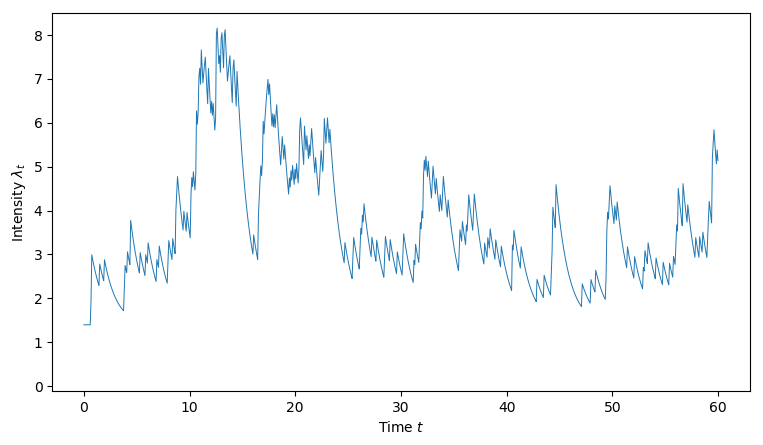

In [58]:
plot_hawkes(hawkes_sample, tmax, lbda0, decay)

In [59]:
times = hawkes_sample[:, 0]

In [60]:
import numpy as np
import numba as nb

We use the formula given in Ogata's 1981 paper to compute the log-likelihood: it is very computationally expensive, so we use Python's `numba` library to pre-compile the functions.

In [62]:
@nb.njit
def _A_func(times, t, decay):
    diff = t - times
    diff = diff[diff > 0]
    return np.sum(np.exp(-decay*diff))
_A_func = np.vectorize(_A_func, excluded={0})

@nb.njit
def _B_func(times, t, decay):
    diff = t - times
    diff = diff[diff > 0]
    return np.sum(diff*np.exp(-decay*diff))
_B_func = np.vectorize(_B_func, excluded={0})

@nb.njit
def _integral_term(times, mu, alpha, decay, tmax):
    diff = tmax - times
    res = mu*tmax + alpha*np.sum(1-np.exp(-decay*diff))
    return res

In [63]:
def hawkes_likelihood(arr, tmax, mu, alpha, decay):
    """
    Compute the log-likelihood of a Hawkes process given by `arr`.
    Args:
        arr[:,0] must be the event times
        tmax (float): temporal horizon
        mu: base event rate
        alpha (float): jump parameter
        decay (float): self-explanatory
    """
    times = arr[:,0]    
    integral = _integral_term(times, mu, alpha, decay, tmax)
    res = _A_func(times, times, decay)
    term2 = np.sum(np.log(mu + alpha*decay*res))
    res = -integral + term2
    return res

hawkes_likelihood = np.vectorize(hawkes_likelihood, excluded={0, 1})

hawkes_likelihood(hawkes_sample, tmax, lbda0, alpha, decay)

array(65.41173737)

In [64]:
print("Real parameters:", (lbda0, alpha, decay))
min_alph = 0.1
max_alpha = 1.6
min_beta = 0.1
max_beta = 1.5
Ngrid = 61
X, Y = np.mgrid[min_alph:max_alpha:Ngrid*1j,min_beta:max_beta:Ngrid*1j]
Z = hawkes_likelihood(hawkes_sample, tmax, lbda0, X, Y)
print()
print(Z)

Real parameters: (1.4, 0.67, 0.85)

[[1.05399030e+01 1.19533049e+01 1.30166242e+01 ... 2.01938657e+01
  2.02229525e+01 2.02511722e+01]
 [1.52685634e+01 1.69121451e+01 1.81454680e+01 ... 2.62365279e+01
  2.62670819e+01 2.62966425e+01]
 [1.95722382e+01 2.14120890e+01 2.27897415e+01 ... 3.15893345e+01
  3.16201632e+01 3.16498945e+01]
 ...
 [1.26779823e+01 1.25891543e+01 1.27720980e+01 ... 5.50681259e+00
  5.34448288e+00 5.18140699e+00]
 [1.07197446e+01 1.05357863e+01 1.06558754e+01 ... 2.94109604e+00
  2.77564091e+00 2.60946352e+00]
 [8.73121708e+00 8.45149584e+00 8.50831330e+00 ... 3.43341928e-01
  1.74781751e-01 5.52331819e-03]]


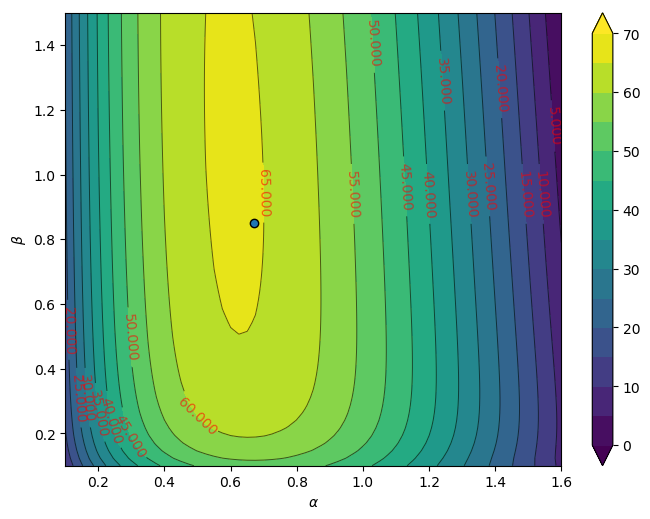

In [70]:
# Plot the log-likelihood in the (alpha, beta) plane

fig, ax = plt.subplots(1,1)
extent = [min_alph, max_alpha, min_beta, max_beta]
# cax = ax.imshow(Z, interpolation='bilinear', origin='lower',
#                 extent=extent, aspect=1)
cs = ax.contour(
    X, Y, Z, 14,
    linewidths=0.7, colors='k',
    alpha=0.6)
csf = ax.contourf(
    X, Y, Z, 14,
    extend='both')
cs.clabel(colors='r')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")
ax.scatter(alpha, decay, edgecolors='k')
cbar = fig.colorbar(csf)

We see the log-likelihood function is quite flat, meaning there will be trouble with a gradient descent algorithm's convergence.